# Lab: Exploring Image Data

# 1. Business Understanding:

&emsp; Facial expressions can be very intuitive about how people are feeling at the moment. Recognizing people's emotions from their expressions is very important in our daily life. But sometimes, people don't want to express or deliberately hide their true emotions, and there are micro-expressions that are hard to pick up with the naked eye. If we can capture people's expressions through machine learning, it could help us perceive or predict people's subsequent actions to effectively interact with them, develop empathy or make accurate judgments about them. The collection of emotion detection datasets can be applied to the field of mental health medication because it can provide psychologists with the real current mental state and emotions of patients. In addition, the data can also be used in the field of criminal investigation because it can assist the police in judging whether the criminal is lying according to the changing categories of the criminal's expression at that time to increase the efficiency of case handling. The predictive task of this dataset is to classify people based on their current expressions. There are seven categories: angry, disgusted, fearful, happy, neutral, sad, and surprised. Once modeling starts, it takes about 20 minutes for prediction algorithm to be considered useful to third parties.<br>
&emsp; By linear or nonlinear dimensionality reduction of images and feature extraction of images and classifiers, we can help psychologists or police to classify the expressions of observed objects more easily and make corresponding judgments according to the predicted expression categories.<br>
&emsp; Different from the traditional methods of manual feature recognition, our machine learning method can process many data sets in a short time and obtain models with high accuracy so as to improve efficiency. If the prediction is good, the accuracy of the emotion classification will be high. Or maybe the classification accuracy isn't as good as we thought, and at least there are some emotional classification errors (like Angry and Disgusted). The poor accuracy may be due to the low resolution of each image in the data set.

# 2. Data Preparation:

## 2.1 Read in your images as numpy arrays. Resize and recolor images as necessary:

## 2.2 Linearize the images to create a table of 1-D iamge features (each row should be one image):

&emsp; In this lab, the dataset we use is from https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer. In the website, the author told us that there are 35685 examples in this dataset. And all the examples are 48x48 pixel gray scale images of faces.

&emsp; Since the original iamge is 48*48 pixels, it does not have to be resized. Recolor all images to gray. Besides, linearize the images to create a table of 1-D image features (data). There are seven expression groups. If we take all the examples into consider, it will take a long time to process. Therefore, we decide to take only the first 1000 examples of each classification for better execution. Since the second expression group does not have 1000 pictures, all the pictures in second group will be taken.

In [1]:
import numpy as np
import os
import cv2
from PIL import Image

dimension = (48, 48)
data = np.empty([0,2304])
target = np.empty([0,1])

for current_node, _, files in os.walk(r'archive/train'):
    index = 0
    for file in files:
        image_path = current_node + '/' + file
        current_image = cv2.imread(image_path)
        # Recolor to gray
        current_image_gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
        image_array = cv2.resize(current_image_gray, dimension)
        # Create a table of 1-D image
        data = np.row_stack((data, image_array.reshape(1, image_array.size)))
        target = np.row_stack((target, np.array([[os.path.basename(os.path.dirname(image_path))]])))
        if index == 1000:
            break
        else:
            index += 1

In [2]:
print(f'Data shape is: {data.shape}')
print(f'Target shape is: {target.shape}')
print(f'Sample number is: {data.shape[0]}')
print(f'Feature number is: {data.shape[1]}')
print(f'Classes number is: {len(np.unique(target))}')
print(f'Original image size is: {dimension[0]} * {dimension[1]}')

Data shape is: (6442, 2304)
Target shape is: (6442, 1)
Sample number is: 6442
Feature number is: 2304
Classes number is: 7
Original image size is: 48 * 48


## 2.3 Visualize several images:
&emsp; In this part, we have displayed 3 columns and 3 rows, totally 9 images as examples.

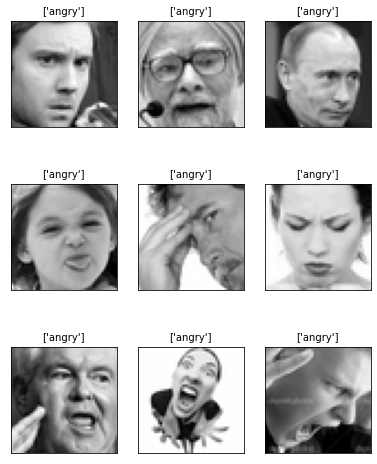

In [3]:
import matplotlib.pyplot as plt

def plot_gallery(images, labels, height, width, n_row=3, n_col=3):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(labels[i], size=10)
        plt.xticks(())
        plt.yticks(())

plot_gallery(data, target, dimension[0], dimension[1])

# 3. Data Reduction:

## 3.1 Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion:

&emsp; In this part, we should use principal components analysis (PCA) to reduce linear dimensionality of our image samples. We try to extract top 50 eigenvectors and plot explained variance changing figure in the first place.

In [4]:
from sklearn.decomposition import PCA

n_components = 50
pca = PCA(n_components=n_components)
%time pca.fit(data.copy())

CPU times: total: 3 s
Wall time: 589 ms


PCA(n_components=50)

In [5]:
import plotly
from plotly.graph_objs import Bar, Line
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs.scatter import Marker
from plotly.graph_objs.layout import XAxis, YAxis

In [6]:
def plot_explained_variance(pca):
    plotly.offline.init_notebook_mode()
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

In [7]:
%time plot_explained_variance(pca)

CPU times: total: 453 ms
Wall time: 460 ms


&emsp; According to the figure above, we can see that the individual explained variance of every eigenvector can hardly see after the 40th eigenvector. And The first 40 eigenvector has already obtained more than 82 percent of explained variance. Therefore, we think using 40 principal components to implement PCA is sufficient.

## 3.2 Perform linear dimensionality reduction of your image data using randomized principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion:

&emsp; In this part, we should use randomized PCA to reduce linear dimensionality of our image samples. We also firstly try to extract top 50 eigenvectors and plot explained variance changing figure with those eigenvectors.

In [8]:
n_components = 50
rpca = PCA(n_components=n_components, svd_solver='randomized')
%time rpca.fit(data.copy())

CPU times: total: 4.25 s
Wall time: 855 ms


PCA(n_components=50, svd_solver='randomized')

In [9]:
%time plot_explained_variance(rpca)

CPU times: total: 62.5 ms
Wall time: 66 ms


&emsp; As we can see from the figure above, the individual explained variance of every eigenvector is nearly invisible after the 40th eigenvector. And The first 40 eigenvector has already obtained more than 82 percent of explained variance. Therefore, we think taking 40 principal components to implement Ramdimized PCA is also sufficient.

## 3.3 Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components. Do you prefer one method over another? Why?:

In [10]:
from skimage.metrics import structural_similarity as ssim
# https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html

#n_components = 40

def plt_reconstruct(idx):
    data_flag = data[idx].reshape(1, -1)
    reconstructed_image = pca.inverse_transform(pca.transform(data_flag.copy()))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(data_flag.copy()))
    
    original_similarity = ssim(data[idx].reshape((dimension[1], dimension[0])),
                    data[idx].reshape((dimension[1], dimension[0])), 
                    data_range=data[idx].max() - data[idx].min())
    fpca_similarity = ssim(data[idx].reshape((dimension[1], dimension[0])),
                reconstructed_image.reshape((dimension[1], dimension[0])),
                data_range=reconstructed_image.max() - reconstructed_image.min())
    rpca_similarity = ssim(data[idx].reshape((dimension[1], dimension[0])),
                reconstructed_image_rpca.reshape((dimension[1], dimension[0])),
                data_range=reconstructed_image_rpca.max() - reconstructed_image_rpca.min())
    
    plt.figure(figsize=(dimension[1], dimension[0]))
    
    ax=plt.subplot(1,3,1)
    plt.imshow(data[idx].reshape((dimension[1], dimension[0])), cmap=plt.cm.gray)
    ax.set_xlabel(f'Similarity: {original_similarity:.4f}',fontsize=50)
    plt.title(f"Original, {data_flag.shape[1]} elements",fontsize=50)
    plt.grid(False)

    ax=plt.subplot(1,3,2)
    plt.imshow(reconstructed_image.reshape((dimension[1], dimension[0])), cmap=plt.cm.gray)
    ax.set_xlabel(f'Similarity: {fpca_similarity:.4f}',fontsize=50)
    plt.title(f'PCA, {n_components} elements',fontsize=50)
    plt.grid(False)
    
    ax=plt.subplot(1,3,3)
    plt.imshow(reconstructed_image_rpca.reshape((dimension[1], dimension[0])), cmap=plt.cm.gray)
    ax.set_xlabel(f'Similarity: {rpca_similarity:.4f}',fontsize=50)
    plt.title(f'Randomized PCA, {n_components} elements',fontsize=50)
    plt.grid(False)

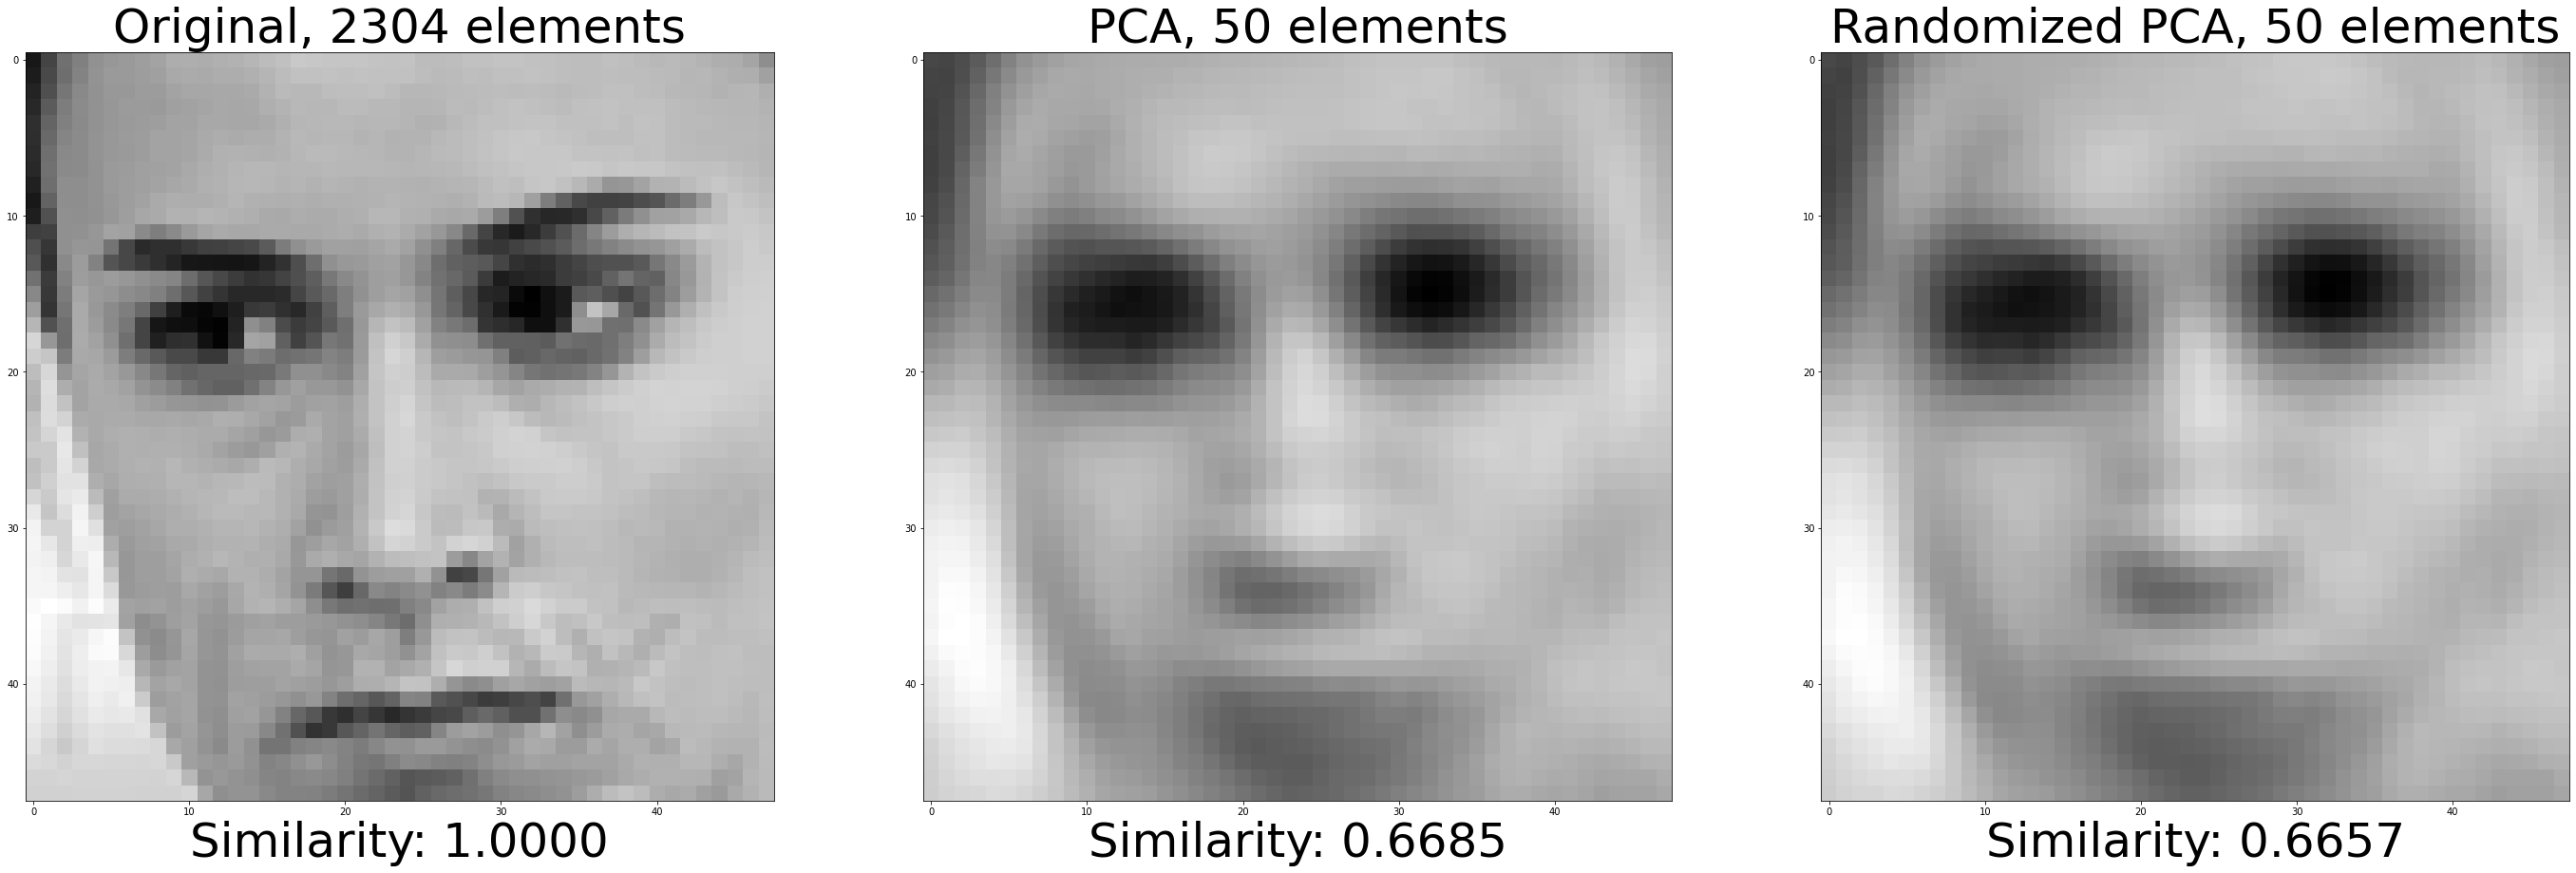

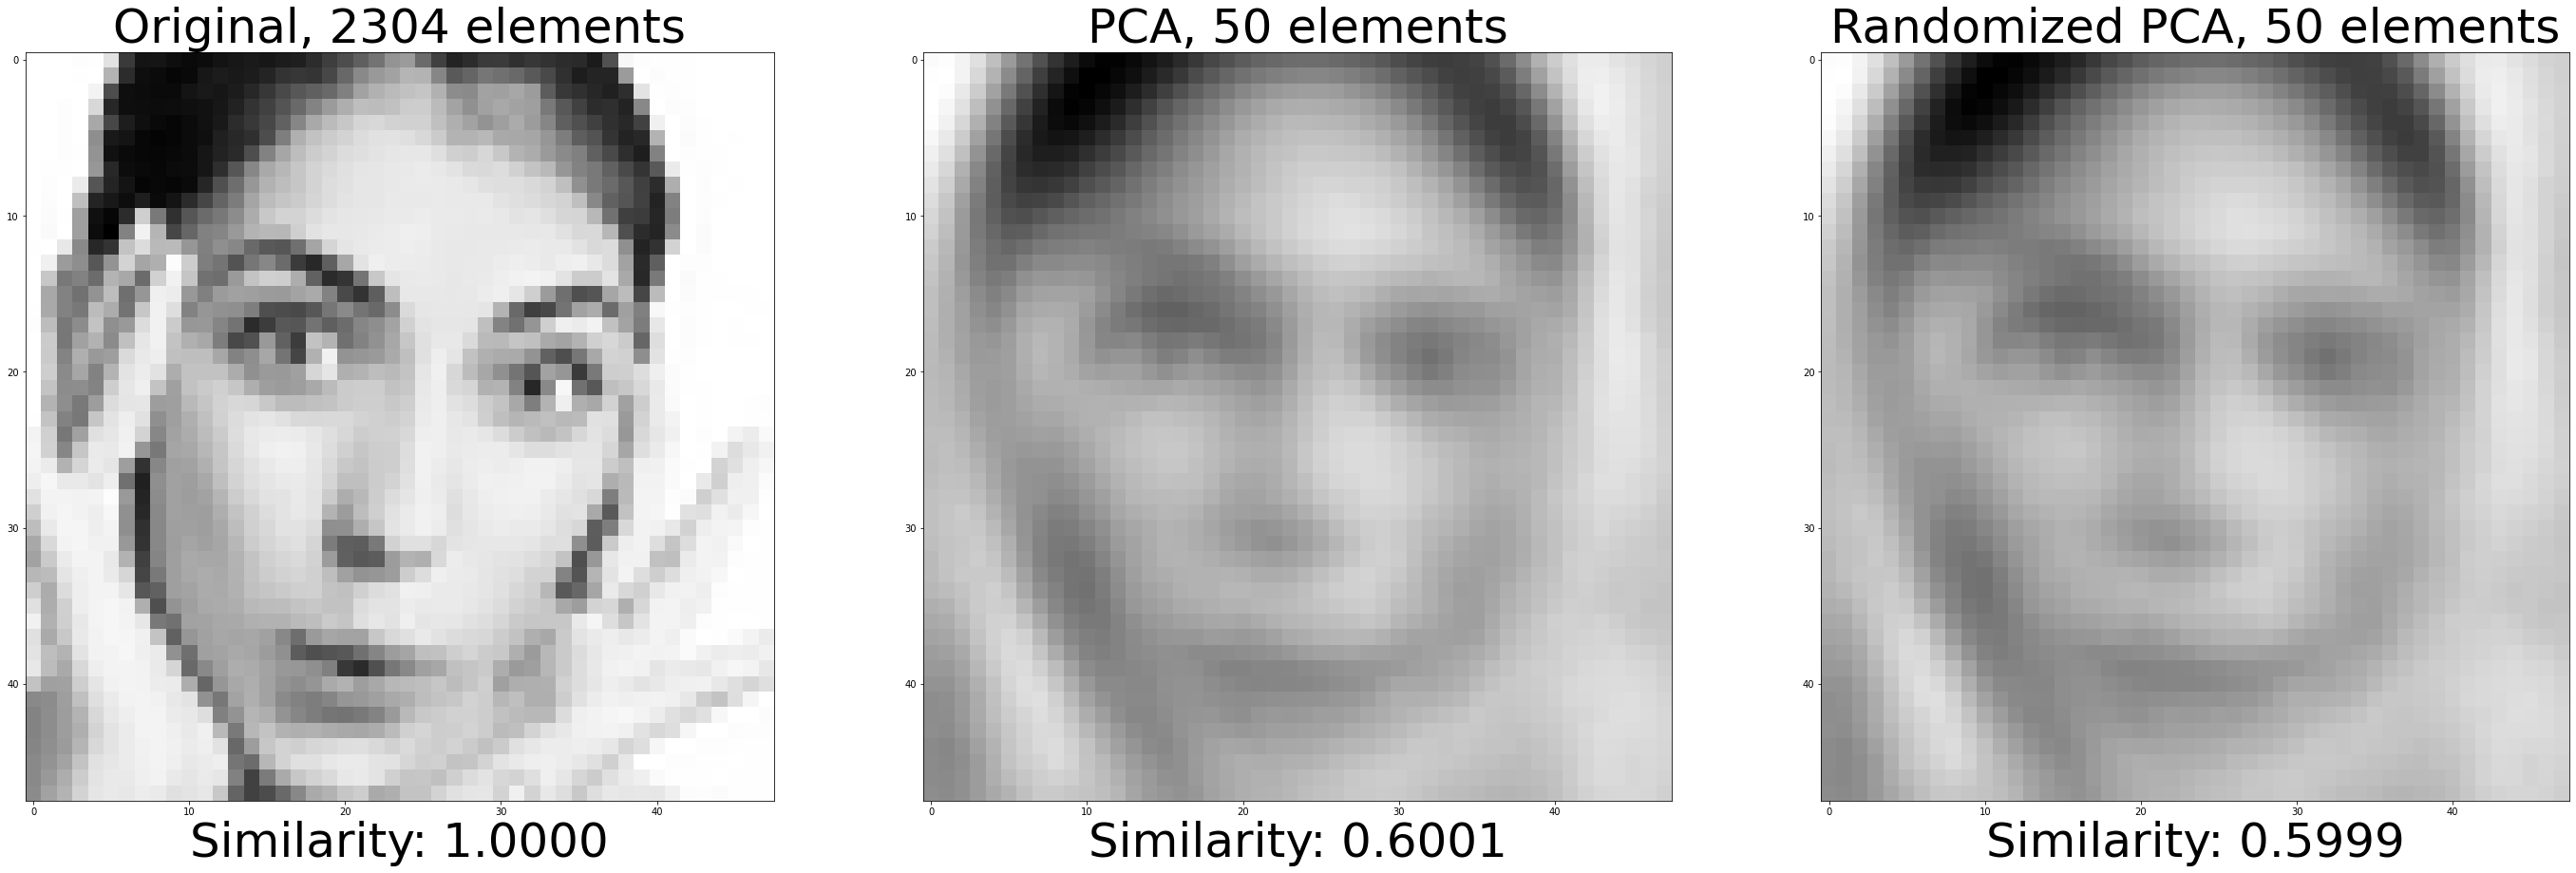

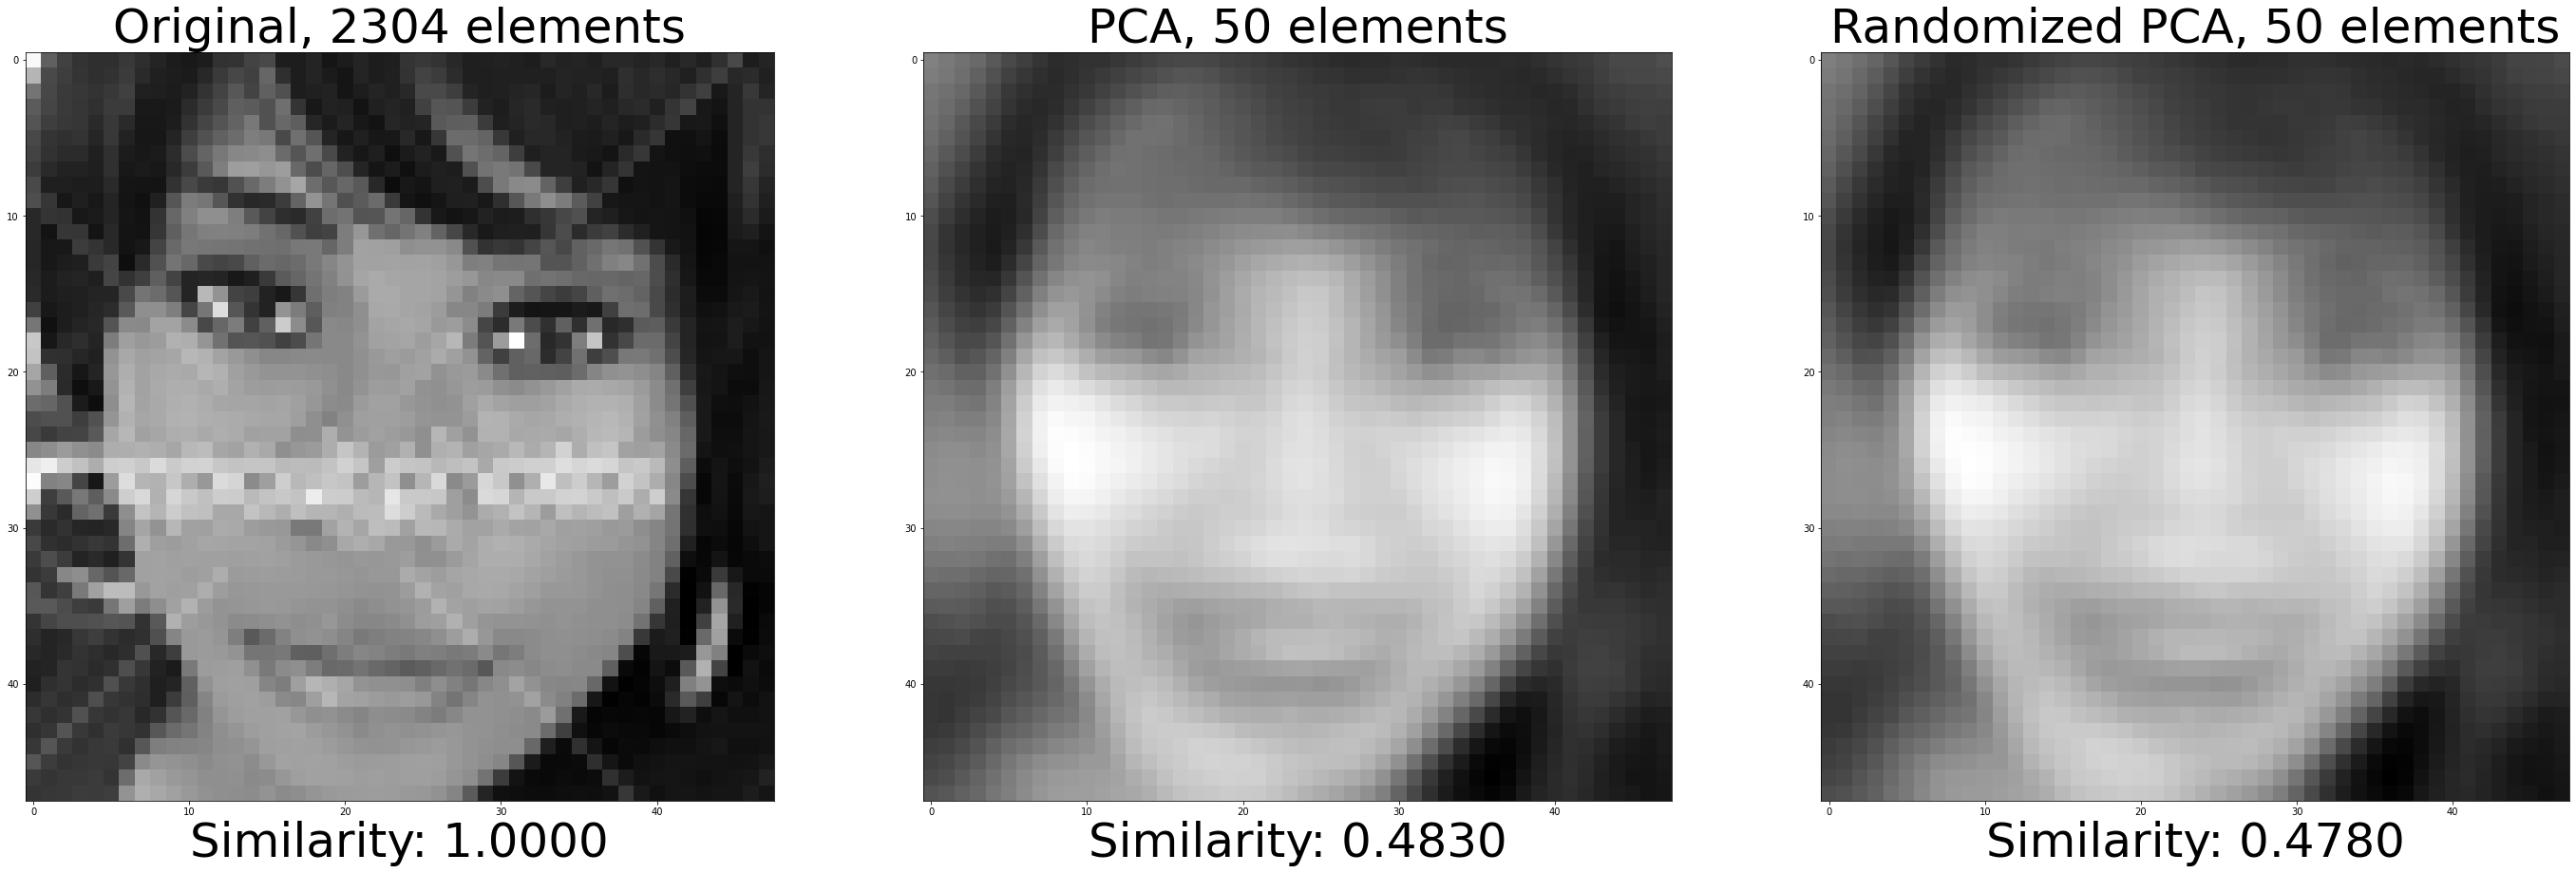

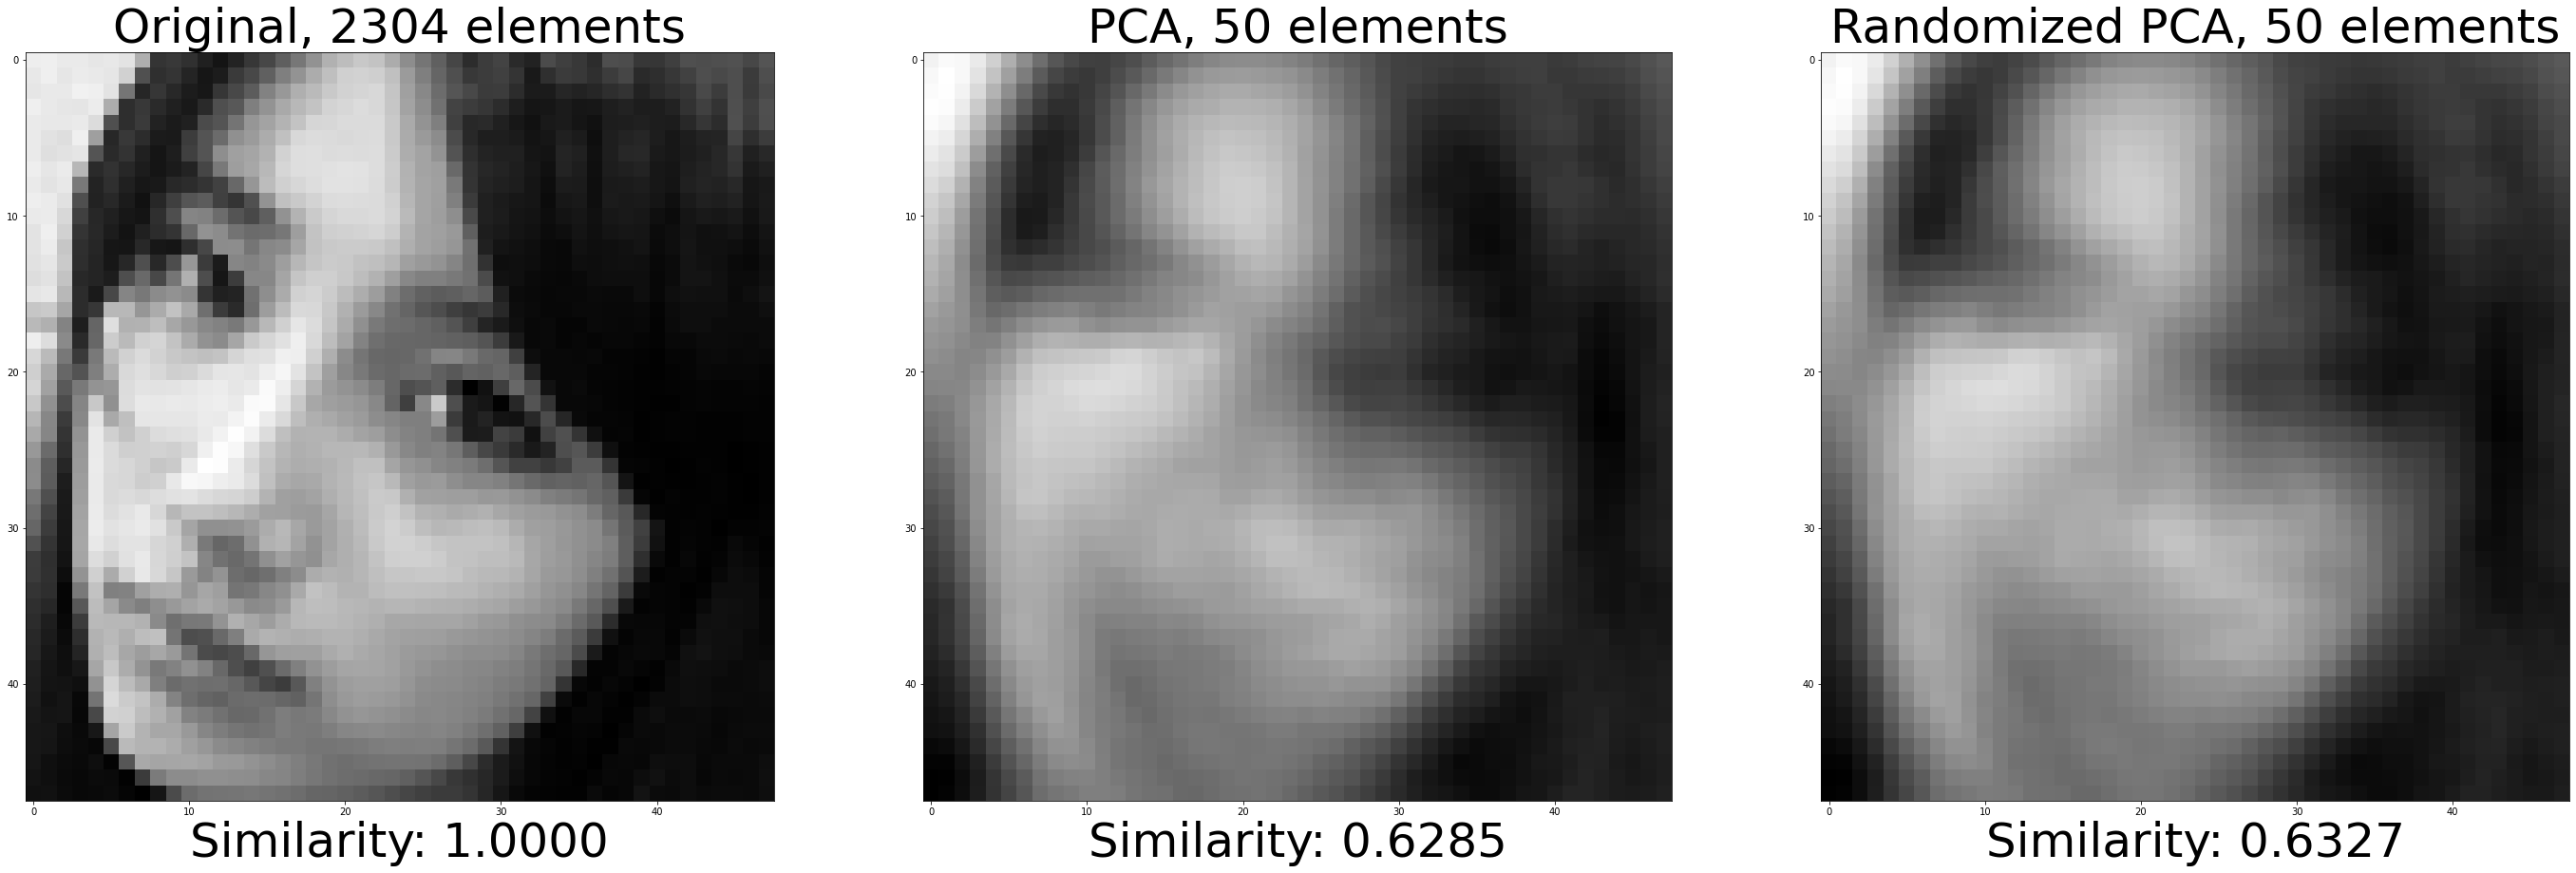

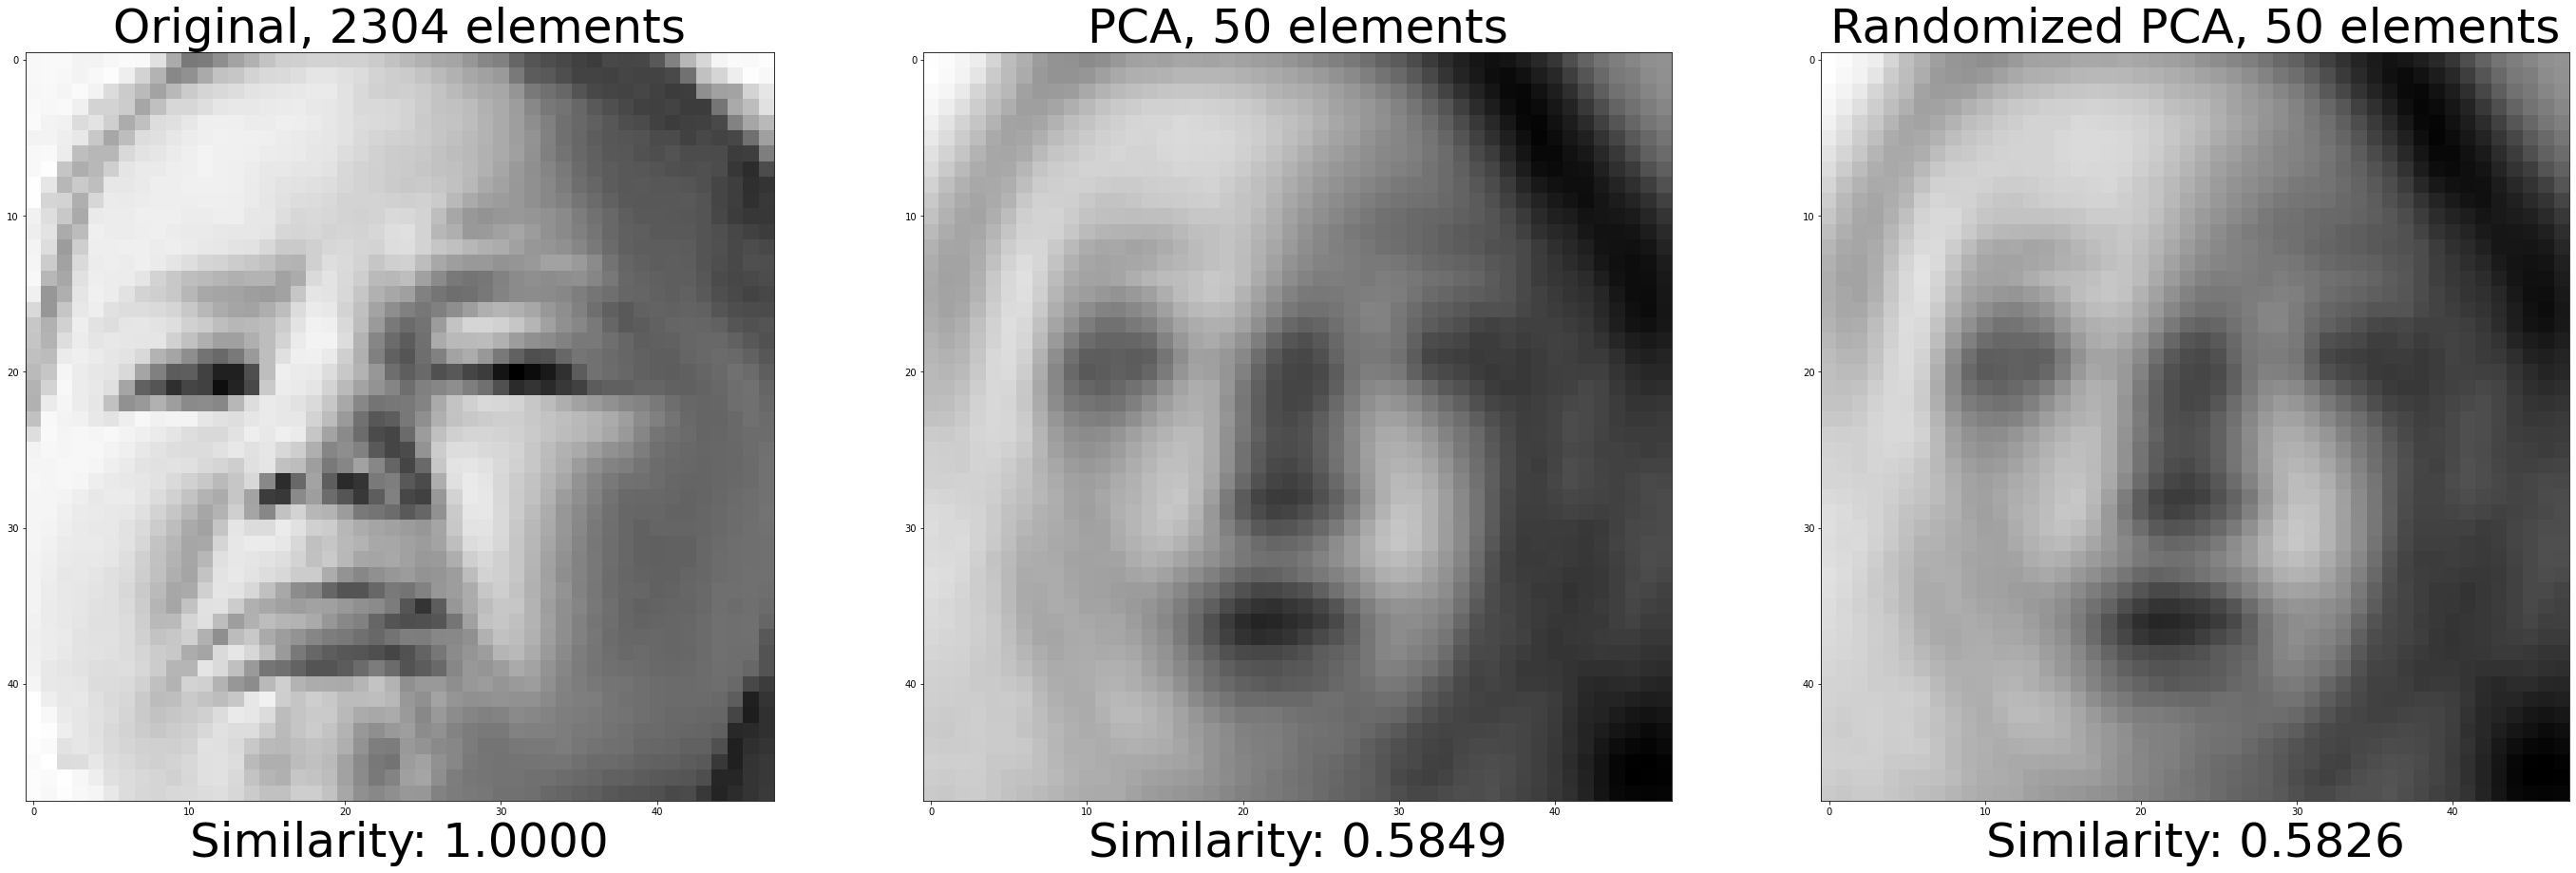

In [11]:
plt_reconstruct(np.random.randint(0,len(data)))
plt_reconstruct(np.random.randint(0,len(data)))
plt_reconstruct(np.random.randint(0,len(data)))
plt_reconstruct(np.random.randint(0,len(data)))
plt_reconstruct(np.random.randint(0,len(data)))

&emsp; According several images and similarity results above, we can see that in most of cases, the similarity results of images outputed by PCA are just slightly higher than the similarity results of images outputed by Randomized PCA when the number of components is low. Therefore, we can conclude that the output accuracy of PCA and Randomized PCA is not much different when the number of components is relatively small. However, the execution speed of Randomized PCA might be faster than the execution speed of PCA because Randomized PCA can conduct eigenvector in a faster way. In that case, we would prefer to implement Randomized PCA instead of PCA when we takes only a few number of components.

## 3.4 Perform feature extraction upon the images using any feature extraction technique (e.g., Gabor filters, ordered gradients, DAISY, etc.):

We choose DAISY to perform feature extraction.

In [12]:
from skimage.feature import daisy

def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=15, radius=20, 
                 rings=4, histograms=6, orientations=8, 
                 visualize=False)
    return feat.reshape((-1))

%time daisy_features = np.apply_along_axis(apply_daisy, 1, data, (dimension[0],dimension[1]))
daisy_features.shape

CPU times: total: 51.3 s
Wall time: 51.8 s


(6442, 200)

&emsp; Feature number went down from 2304 to 200.

## 3.5 Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this question. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance:

In [13]:
import copy
from sklearn.metrics.pairwise import pairwise_distances
from skimage.io import imshow
from ipywidgets import widgets, fixed

dist_matrix = pairwise_distances(copy.deepcopy(daisy_features), metric="seuclidean")

def closest_image(dmat_pca, idx1):
    print(f'idx1 is: {idx1}')
    distances = copy.deepcopy(dist_matrix[idx1,:])
    
    distances[idx1] = np.infty
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(dimension[1],dimension[0]))
    
    plt.subplot(1,3,1)
    plt.imshow(data[idx1].reshape((dimension[1], dimension[0])), cmap=plt.cm.gray)
    plt.title(f"Original: {target[idx1]}", fontsize=50)
    plt.grid(False)

    plt.subplot(1,3,2)
    plt.imshow(data[idx2].reshape((dimension[1], dimension[0])), cmap=plt.cm.gray)
    plt.title(f"Closest: {target[idx2]}", fontsize=50)
    plt.grid(False)
    
    plt.subplot(1,3,3)
    plt.imshow(data[idx3].reshape((dimension[1], dimension[0])), cmap=plt.cm.gray)
    plt.title(f"Next Closest: {target[idx3]}", fontsize=50)
    plt.grid(False)
    
widgets.interact(closest_image,
                 dmat_pca=fixed(dist_matrix),
                 idx1=(0,data.shape[0]-1,1),
                 __manual=True)

interactive(children=(IntSlider(value=3220, description='idx1', max=6441), Output()), _dom_classes=('widget-in…

<function __main__.closest_image(dmat_pca, idx1)>

&emsp; According to three images above, we can conduct that the DAISY feature extraction method is kind of sufficient to our prediction task. Because the last two smiling faces are correctly classified into the happy group.

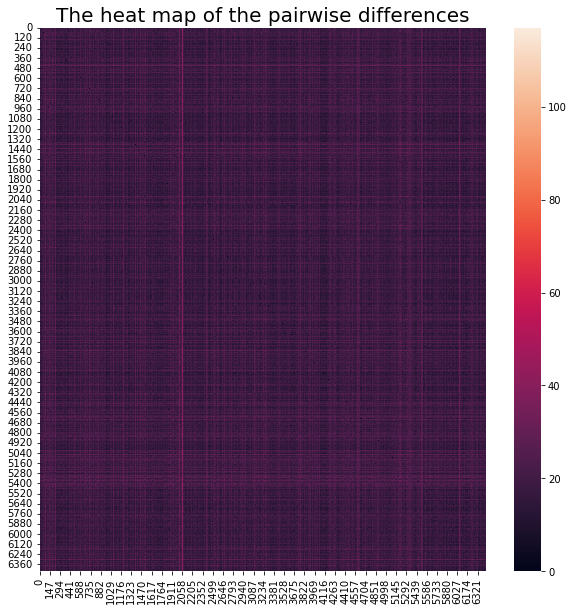

In [14]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.title("The heat map of the pairwise differences",fontsize=20)
sns.heatmap(dist_matrix)
plt.show()

&emsp; Thw hot map above has benn ordered by class. The sequence is angry(0-999), disgusted(1000-1435), fearful(1436-2435), happy(2436-3435), neutral(3436-4435), sad(4436-5435), and surprised(5436-6435).

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

pca_features = pca.transform(copy.deepcopy(data))
rpca_features = rpca.transform(copy.deepcopy(data))

knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_rpca = KNeighborsClassifier(n_neighbors=5)
knn_dsy = KNeighborsClassifier(n_neighbors=5)

target = target.ravel()

pca_train, pca_test, \
rpca_train, rpca_test, \
dsy_train, dsy_test, \
y_train, y_test = train_test_split(pca_features, rpca_features,
                                   daisy_features, target,
                                   test_size=0.1, train_size=0.9)

knn_pca.fit(pca_train,y_train)
pca_accurate = accuracy_score(knn_pca.predict(pca_test),y_test)

knn_pca.fit(rpca_train,y_train)
rpca_accurate = accuracy_score(knn_pca.predict(rpca_test),y_test)

knn_dsy.fit(dsy_train,y_train)
dsy_accurate = accuracy_score(knn_dsy.predict(dsy_test),y_test)

print(f'PCA accuracy is: {100*pca_accurate:.2f}%')
print(f'RPCA accuracy is: {100*rpca_accurate:.2f}%')
print(f'DSY accuracy is: {100*dsy_accurate:.2f}%')

PCA accuracy is: 24.03%
RPCA accuracy is: 24.03%
DSY accuracy is: 29.30%


&emsp; As we can see the different accuracy results produced by different techniques above, DAISY is the best technique to achieve our prediction task compare to the PCA and Randomized PCA.

# 4. Exceptional Work:

&emsp; Using Harris corner detection + DAISY description[1]:

In [16]:
dimension = (48, 48)
data = np.empty([0,2304])
target = np.empty([0,1])

for current_node, _, files in os.walk(r'archive/train'):
    index = 0
    for file in files:
        image_path = current_node + '/' + file
        current_image = cv2.imread(image_path)
        current_image_gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
        current_image_gray = np.float32(current_image_gray)
        dst = cv2.cornerHarris(current_image_gray,2,3,0.2)
        dst = cv2.dilate(dst,None)
        current_image_gray[dst>0.01*dst.max()]=[0]
        image_array = cv2.resize(current_image_gray, dimension)
        data = np.row_stack((data, image_array.reshape(1, image_array.size)))
        target = np.row_stack((target, np.array([[os.path.basename(os.path.dirname(image_path))]])))
        if index == 1000:
            break
        else:
            index += 1

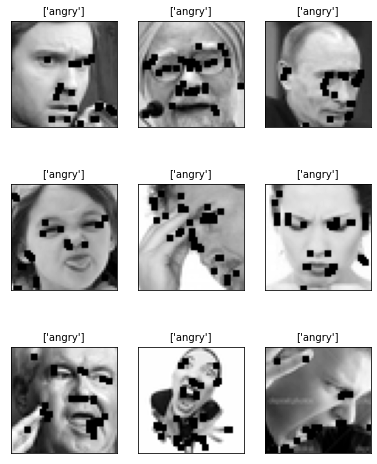

In [17]:
#plt_gallery(data, target, dimension[0], dimension[1])
plot_gallery(data, target, dimension[0], dimension[1])

In [18]:
Harris_knn_dsy = KNeighborsClassifier(n_neighbors=5)
Harris_daisy_features = np.apply_along_axis(apply_daisy, 1, data, (dimension[0],dimension[1]))
target = target.ravel()
dsy_train, dsy_test, y_train, y_test = train_test_split(Harris_daisy_features, target,
                                                        test_size=0.1, train_size=0.9)
Harris_knn_dsy.fit(dsy_train,y_train)
dsy_accurate = accuracy_score(Harris_knn_dsy.predict(dsy_test),y_test)
print(f"Daisy accuracy with Harris corner detection is: {100*dsy_accurate:.2f}%")

Daisy accuracy with Harris corner detection is: 27.13%


&emsp; Using SIFT keypoint detection + DAISY description[2]:

In [19]:
dimension = (48, 48)
data = np.empty([0,2304])
target = np.empty([0,1])

for current_node, _, files in os.walk(r'archive/train'):
    index = 0
    for file in files:
        image_path = current_node + '/' + file
        current_image = cv2.imread(image_path)
        current_image_gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        kp = sift.detect(current_image_gray,None)
        current_image=cv2.drawKeypoints(current_image_gray,kp,current_image)
        current_image_gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
        image_array = cv2.resize(current_image_gray, dimension)
        data = np.row_stack((data, image_array.reshape(1, image_array.size)))
        target = np.row_stack((target, np.array([[os.path.basename(os.path.dirname(image_path))]])))
        if index == 1000:
            break
        else:
            index += 1

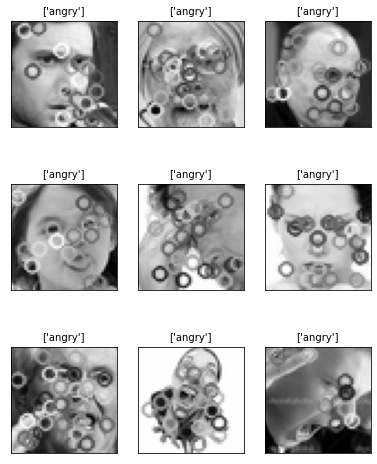

In [20]:
plot_gallery(data, target, dimension[0], dimension[1])
#plt_gallery(data, target, dimension[0], dimension[1])

In [21]:
SIFT_knn_dsy = KNeighborsClassifier(n_neighbors=5)
SIFT_daisy_features = np.apply_along_axis(apply_daisy, 1, data, (dimension[0],dimension[1]))
target = target.ravel()
dsy_train, dsy_test, y_train, y_test = train_test_split(SIFT_daisy_features, target,
                                                        test_size=0.1, train_size=0.9)
SIFT_knn_dsy.fit(dsy_train,y_train)
dsy_accurate = accuracy_score(SIFT_knn_dsy.predict(dsy_test),y_test)
print(f"Daisy accuracy with SIFT keypoint detection is: {100*dsy_accurate:.2f}%")

Daisy accuracy with SIFT keypoint detection is: 22.33%


&emsp; In this part, we have combined two different key point matching methods with DAISY, which are Harris corner detection and SIFT keypoint detection[3]. In order to determine which technique is more appropriate to combine with DAISY, we have built the nearest neighbor classifier to the both of techniques. As the accuracy produced above, the output accuracy of Harris corner detection is higher than the output accuracy of SIFT keypoint detection. We can conduct that the Harris corner detection is a better technique to combine with DAISY compared with SIFT keypoint detection so that our prediction task could be sufficiently achieved.

# 5. Reference

1. https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html
2. https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
3. Y. Guo, Z. -C. Mu, H. Zeng and K. Wang, "Fast Rotation-Invariant DAISY Descriptor for Image Keypoint Matching," 2010 IEEE International Symposium on Multimedia, 2010, pp. 183-190, doi: 10.1109/ISM.2010.34.